In [2]:
import numpy as np
import scipy.fft as fft
import matplotlib.pyplot as plt
from scipy.linalg import matmul_toeplitz

from ppfft.tools.grids import domain
from ppfft.tools.phantom_generator import generate_phantom

# Forward PPFFT

We work with an image $I$ of size $n \times n$ where $n$ is even. We try this new definition of the PPFFT for the basically horizontal lines:
$$
\forall (k, l) \in \llbracket 0, n/2 \rrbracket \times \llbracket -n/2, n/2 \rrbracket, \widehat{I}_h (k, l) = \sum_{u=0}^{n-1} \sum_{v=0}^{n-1} I(u, v) \exp\left(-2i\pi \frac{-\frac{2lk}{n}u + kv}{n + 1} \right)
$$

We can rewrite it:
$$
\begin{align*}
\widehat{I}_h (k, l) = \sum_{u=0}^{n-1} \left[ \sum_{v=0}^{n-1} I(u, v) \exp\left(-2i\pi \frac{kv}{n+1} \right) \right] \exp\left(-2i\pi \frac{-2lku}{n(n+1)}\right)
\end{align*}
$$

## Frac FFT

In [3]:
def fast_frac_fft(x: np.ndarray, beta: float, m=None) -> np.ndarray:
    n = len(x)
    w = np.exp(-2j * np.pi * beta)
    dom_in = np.arange(n)
    # Output size is the same as input.
    if m is None:
        dom_out = domain(n)
    # Output size given by m.
    else:
        dom_out = domain(m)
    w_powers_in = w ** (0.5 * dom_in**2)
    w_powers_out = w ** (0.5 * dom_out**2)
    c = w ** (-0.5 * (dom_out - dom_in[0]) ** 2)
    r = w ** (-0.5 * (dom_in - dom_out[0]) ** 2)
    return w_powers_out * matmul_toeplitz((c, r), w_powers_in * x)

In [4]:
def true_frac(x, beta, m=None):
    n = len(x)
    u = np.arange(n)
    if m is None:
        k = domain(n)
    else:
        k = domain(m)
    aux = np.exp(-2j * np.pi * u[:, None] * k[None, :] * beta)
    return np.einsum("u,uk->k", x, aux)

In [5]:
n = 10
x = np.random.rand(n)
beta = np.random.rand()

fast_frac_fft(x, beta, 12) - true_frac(x, beta, 12)

array([ 1.15463195e-14-3.22034066e-14j,  2.92127433e-15-2.48134846e-14j,
        2.22044605e-15-1.77635684e-15j,  1.38777878e-15-6.32827124e-15j,
        2.88657986e-15-2.66453526e-15j, -5.99520433e-15+3.10862447e-15j,
       -8.88178420e-16+1.69176842e-16j,  2.99760217e-15+3.99680289e-15j,
       -2.66453526e-15+1.08801856e-14j, -9.76996262e-15+5.32907052e-15j,
       -7.77156117e-15-5.32907052e-15j,  4.19803081e-15+4.05231404e-15j])

## New horizontal PPFFT

In [6]:
def ppfft_horizontal(a: np.ndarray) -> np.ndarray:
    n, _ = a.shape

    res = np.empty((1 + n // 2, n + 1), dtype=complex)

    # 1D FFT of each zero-padded line. Shape = (n, n + 1)
    fft_col = fft.fft(a, n=n+1, axis=-1)[:, :1 + n // 2]
    # Frac FFT on each col
    for k, col in enumerate(fft_col.T):
        res[k, :] = fast_frac_fft(col, beta= -2 * k / (n * (n + 1)), m=n+1)
    return res

In [7]:
def slow_DTFT(a, omega_u, omega_v, m):
    n, _ = a.shape
    u = np.arange(n)
    v = np.arange(n)
    return np.einsum("uv,u,v->", a, np.exp(-2j * np.pi * omega_u * u / m), np.exp(-2j * np.pi * omega_v * v / m))

In [8]:
n = 100
a = np.random.rand(n, n)
hori_ppfft = ppfft_horizontal(a)

In [9]:
true_hori_ppfft = np.empty(shape=(n // 2 + 1, n + 1), dtype=complex)

for i_l, l in enumerate(domain(n + 1)):
    for i_k, k in enumerate(np.arange(0, n//2 + 1)):
        true_hori_ppfft[i_k, i_l] = slow_DTFT(a, -2 * l * k / n, k, n + 1)

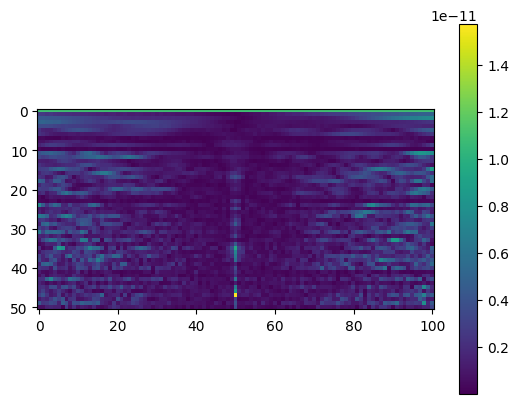

In [10]:
plt.imshow(np.abs(hori_ppfft - true_hori_ppfft))
plt.colorbar()

## New vertical PPFFT

In [11]:
def ppfft_vertical(a):
    return ppfft_horizontal(a.T)

In [12]:
vert_ppfft = ppfft_vertical(a)

In [13]:
true_vert_ppfft = np.empty(shape=(n // 2 + 1, n + 1), dtype=complex)

for i_l, l in enumerate(domain(n + 1)):
    for i_k, k in enumerate((np.arange(0, n//2 + 1))):
        true_vert_ppfft[i_k, i_l] = slow_DTFT(a, k, -2 * l * k / n, n + 1)

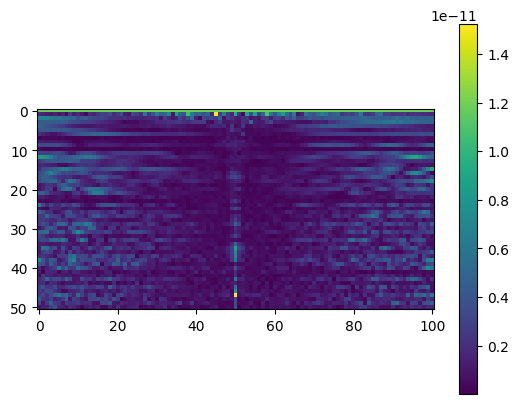

In [14]:
plt.imshow(np.abs(vert_ppfft - true_vert_ppfft))
plt.colorbar()

# New resampling

Convention:
$$
P_\alpha(x) = \sum_{u=0}^{n-1} \alpha(u) \exp(iux)
$$

In [14]:
from scipy.linalg import toeplitz
from ppfft.toeplitz.inverse_toeplitz import InverseToeplitz
from pynufft import NUFFT
from ppfft.inverse.onion_peeling import select_points

[ 0.82503962-0.79801942j  1.04956565-0.3537491j  -0.67863689-0.1062022j
  0.35073761+1.06154711j -0.33510603+1.92555624j  5.24172386+0.j
 -0.33510603-1.92555624j  0.35073761-1.06154711j -0.67863689+0.1062022j
  1.04956565+0.3537491j   0.82503962+0.79801942j]
4.755534445025903
[0.64169216 0.31164468 0.98159201 0.47767645 0.53706737 0.55744948
 0.58516561 0.12900823 0.67048034 0.34995022]
[0.64169226 0.3116445  0.98159094 0.47767609 0.5370673  0.55744932
 0.58516509 0.12900784 0.67048011 0.3499504 ]
1.066951858641474e-06


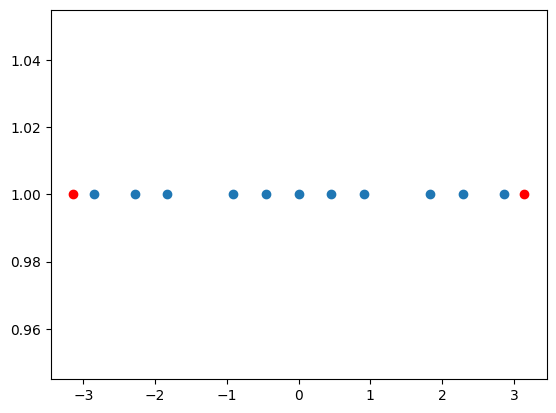

In [15]:
def trigo_poly(alpha, x):
    n = len(alpha)
    u = np.arange(n)
    # u = domain(n)
    ux = np.einsum("u,x->ux", u, x)
    return np.einsum("ux,u->x", np.exp(1j * ux), alpha)

n = 10
k = -(n//2) + 1
alpha = np.random.rand(n)
ppfft_pos = 4 * np.pi * np.arange(-(n//2), n//2 + 1) * k / (n * (n + 1))
samples = trigo_poly(alpha, ppfft_pos)

indices = select_points(k, n)
take_ppfft_pos = np.take(ppfft_pos, indices)
take_samples = np.take(samples, indices)

y_pos = -2 * np.pi * np.arange(-(n//2), k) / (n + 1)
y_neg = 2 * np.pi * np.arange(-(n//2), k)[::-1] / (n + 1)

y = np.concatenate((y_pos, take_ppfft_pos, y_neg)) # condition number explodes if we don not add these points
f = trigo_poly(alpha, y)
print(f)
plt.scatter(y, np.ones_like(y))
plt.scatter([-np.pi, np.pi], [1, 1], c='r')

c = np.einsum("lj->l", np.exp(-1j * np.arange(0, n)[:, None] * y[None, :]))
print(np.linalg.cond(toeplitz(c)))
top = InverseToeplitz(col=c)
NufftObj = NUFFT()
NufftObj.plan(om=-y[:, None], Nd=(n,), Kd=(5 * n,), Jd=(6,))
sol = top.apply_inverse(NufftObj.Kd * NufftObj.adjoint(np.exp(-1j * y * (n // 2)) * f))
print(sol.real)
print(alpha)

print(np.max(np.abs(sol.real - alpha)))

## Initializing $\widehat{I}$

Version without `fft.fftshift`, meaning `I_hat = fft.fft2(im, s=(n+1, n+1))`

/tmp/ipykernel_1440415/1357810520.py:36: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(fft.fft2(a, s=(n+1, n+1)) - I_hat)))


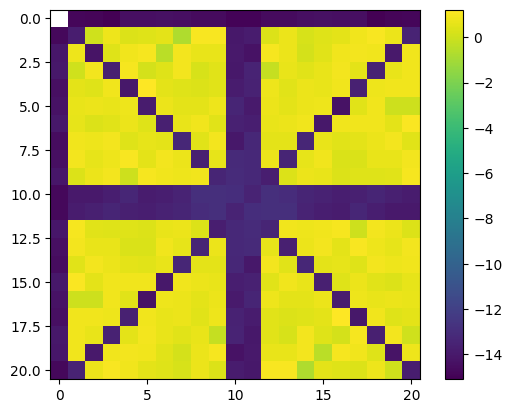

In [16]:
def initialize_I_hat(hori_ppfft, vert_ppfft):
    n = np.shape(hori_ppfft)[1] - 1
    I_hat = np.zeros(shape=(n + 1, n + 1), dtype=complex) # shape (n + 1, n + 1)

    # k = 0
    I_hat[0, n//2 + 1:] = np.conjugate(hori_ppfft[1:, n//2])[::-1]
    I_hat[0, :n//2 + 1] = hori_ppfft[:, n//2]

    # l = 0
    I_hat[n//2 + 1:, 0] = np.conjugate(vert_ppfft[1:, n//2])[::-1]
    I_hat[:n//2 + 1, 0] = vert_ppfft[:, n//2]

    # k = - n//2
    I_hat[n//2 + 1, :] = fft.ifftshift(np.conjugate(vert_ppfft[-1, :]))

    # k = n//2
    I_hat[n//2, :] = fft.ifftshift(vert_ppfft[-1, ::-1])

    # l = - n//2
    I_hat[:, n//2 + 1] = fft.ifftshift(np.conjugate(hori_ppfft[-1, :]))

    # l = n//2
    I_hat[:, n//2] = fft.ifftshift(hori_ppfft[-1, ::-1])

    np.fill_diagonal(I_hat, np.concatenate((hori_ppfft[:, 0], np.conjugate(hori_ppfft[1:, 0])[::-1])))

    np.fill_diagonal(np.fliplr(I_hat)[1:], np.concatenate((vert_ppfft[1:, -1], np.conjugate(vert_ppfft[1:, -1])[::-1])))

    return I_hat

n = 20
a = np.random.rand(n, n)
hori_ppfft = ppfft_horizontal(a)
vert_ppfft = ppfft_vertical(a)
I_hat = initialize_I_hat(hori_ppfft, vert_ppfft)
plt.imshow(np.log10(np.abs(fft.fft2(a, s=(n+1, n+1)) - I_hat)))
plt.colorbar()

In [17]:
def precompute_onion_peeling(n: int, oversampling_factor: int = 5):
    half_n = n // 2
    toeplitz_list = []
    nufft_list = []

    for k in range(half_n - 1, 0, -1):
        y_ppfft = 4 * np.pi * np.arange(-(n//2), n//2 + 1) * k / (n * (n + 1))
        indices = select_points(k, n)
        y_ppfft = np.take(y_ppfft, indices)

        y_pos = -2 * np.pi * np.arange(-(n//2), -k) / (n + 1)
        y_neg = 2 * np.pi * np.arange(-(n//2), -k)[::-1] / (n + 1)

        y = np.concatenate((y_pos, y_ppfft, y_neg))

        c = np.einsum("lj->l", np.exp(-1j * np.arange(0, n)[:, None] * y[None, :]))

        toeplitz_list.append(InverseToeplitz(col=c))

        NufftObj = NUFFT()
        NufftObj.plan(om=-y[:, None], Nd=(n,), Kd=(oversampling_factor * n,), Jd=(6,))
        NufftObj.arr = np.exp(-1j * y * (n // 2))

        nufft_list.append(NufftObj)

    return toeplitz_list, nufft_list

def my_compute_rows(k, I_hat, vert_ppfft_samples, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    0 < k < n//2
    """
    n = np.shape(I_hat)[0] - 1
    # Step: 1, 2, ..., n//2 - 1

    I_hat_pos = I_hat[k, n//2 + 1:n - k + 1]
    I_hat_neg = I_hat[k, k+1:n//2+1]

    known_samples = np.concatenate((I_hat_pos, vert_ppfft_samples, I_hat_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(NufftObj.arr * known_samples))

    res = fft.fft(alpha, n=n+1)

    # Positive row
    I_hat[k, n - k + 2 : n + 1] = res[n - k + 2 : n + 1]
    I_hat[k, 1 : k] = res[1 : k]

    # Negative row
    I_hat[-k, n - k + 2 : n + 1] = np.conjugate(res[1 : k])[::-1]
    I_hat[-k, 1 : k] = np.conjugate(res[n - k + 2 : n + 1])[::-1]

    return alpha


def my_compute_cols(k, I_hat, hori_ppfft_samples, toeplitz_inv: InverseToeplitz, NufftObj: NUFFT):
    """
    0 < k < n//2
    """
    n = np.shape(I_hat)[0] - 1
    # Step: 1, 2, ..., n - 1

    I_hat_pos = I_hat[n//2 + 1:n - k + 1, k]
    I_hat_neg = I_hat[k+1:n//2+1, k]

    known_samples = np.concatenate((I_hat_pos, hori_ppfft_samples, I_hat_neg))

    alpha = toeplitz_inv.apply_inverse(NufftObj.Kd * NufftObj.adjoint(NufftObj.arr * known_samples))

    res = fft.fft(alpha, n=n+1)

    # Positive row
    I_hat[n - k + 2 : n + 1, k] = res[n - k + 2 : n + 1]
    I_hat[1 : k, k] = res[1 : k]

    # Negative row
    I_hat[n - k + 2 : n + 1, -k] = np.conjugate(res[1 : k])[::-1]
    I_hat[1 : k, -k] = np.conjugate(res[n - k + 2 : n + 1])[::-1]

    return alpha


def my_onion_peeling(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list):
    I_hat = initialize_I_hat(hori_ppfft, vert_ppfft)
    n = hori_ppfft.shape[1] - 1
    for toeplitz_inv, NufftObj, k in zip(toeplitz_list, nufft_list, range(n//2 - 1, 0, -1)):
        indices = select_points(k, n)
        vert_ppfft_samples = np.take(vert_ppfft[k], indices)
        hori_ppfft_samples = np.take(hori_ppfft[k], indices)

        my_compute_rows(k, I_hat, vert_ppfft_samples, toeplitz_inv, NufftObj)
        my_compute_cols(k, I_hat, hori_ppfft_samples, toeplitz_inv, NufftObj)

    return I_hat

In [18]:
n = 100
toeplitz_list, nufft_list = precompute_onion_peeling(n)
a = np.random.rand(n, n)
hori_ppfft, vert_ppfft = ppfft_horizontal(a), ppfft_vertical(a)
res_onion = my_onion_peeling(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list)

/tmp/ipykernel_1440415/2228124669.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(res_onion - fft.fft2(a, s=(n+1, n+1)))))


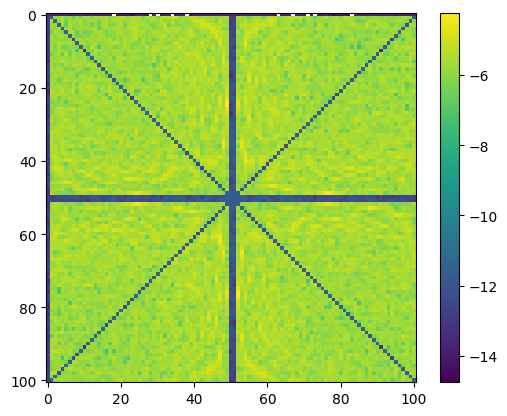

In [19]:
plt.imshow(np.log10(np.abs(res_onion - fft.fft2(a, s=(n+1, n+1)))))
plt.colorbar()

In [20]:
def my_onion_peeling_row(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list):
    I_hat = initialize_I_hat(hori_ppfft, vert_ppfft)
    n = hori_ppfft.shape[1] - 1

    fft_row = np.zeros(shape=(n, n // 2 + 1), dtype=complex)
    fft_row[:, 0] = fft.ifft(I_hat[:, 0])[:-1]
    fft_row[:, -1] = fft.ifft(I_hat[:, n//2])[:-1]

    for toeplitz_inv, NufftObj, k in zip(toeplitz_list, nufft_list, range(n//2 - 1, 0, -1)):
        indices = select_points(k, n)
        vert_ppfft_samples = np.take(vert_ppfft[k], indices)
        hori_ppfft_samples = np.take(hori_ppfft[k], indices)

        my_compute_rows(k, I_hat, vert_ppfft_samples, toeplitz_inv, NufftObj)
        alpha = my_compute_cols(k, I_hat, hori_ppfft_samples, toeplitz_inv, NufftObj)

        fft_row[:, k] = alpha

    return fft_row


def my_direct_inversion(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list):
    fft_row = my_onion_peeling_row(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list)
    return fft.irfft(fft_row, n=n+1)[:, :-1]

In [21]:
n = 1000
toeplitz_list, nufft_list = precompute_onion_peeling(n)

In [22]:
im = generate_phantom(n)
hori_ppfft, vert_ppfft = ppfft_horizontal(im), ppfft_vertical(im)

In [23]:
fft_row = my_onion_peeling_row(hori_ppfft, vert_ppfft, toeplitz_list, nufft_list)

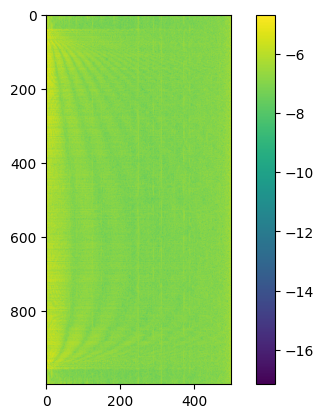

In [24]:
plt.imshow(np.log10(np.abs(fft_row - fft.rfft(im, n=n+1))))
plt.colorbar()

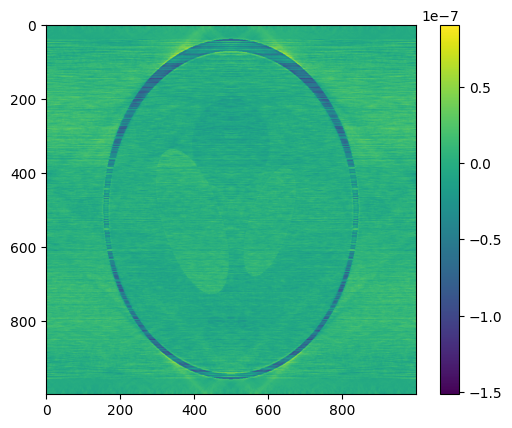

In [25]:
plt.imshow(fft.irfft(fft_row, n=n+1)[:, :-1] - im)
plt.colorbar()

# Interpolation polar $\to$ new pseudopolar

In [28]:
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator

In [29]:
def full_horizontal_grid(n: int) -> np.ndarray:
    dom = domain(n + 1)
    horizontal_x = - 2 * dom[None, :] * dom[:, None] / (n * (n + 1))
    horizontal_y = np.tile(dom[:, None], (1, n + 1)) / (n + 1)
    return horizontal_x, horizontal_y


def full_vertical_grid(n):
    horizontal_x, horizontal_y = full_horizontal_grid(n)
    return horizontal_y, horizontal_x


def half_horizontal_grid(n: int) -> np.ndarray:
    ks = np.arange(0, n // 2 + 1)
    ls = np.arange(- (n // 2), n // 2 + 1)
    horizontal_x = - 2 * ks[:, None] * ls[None, :] / (n * (n + 1))
    horizontal_y = np.tile(ks[:, None], (1, n + 1)) / (n + 1)
    return horizontal_x, horizontal_y


def half_vertical_grid(n):
    horizontal_x, horizontal_y = half_horizontal_grid(n)
    return horizontal_y, horizontal_x


def polar_grid(thetas, n_r):
    """
    n_r should be odd
    """
    rs = domain(n_r) / n_r

    polar_x = np.cos(thetas)[:, None] * rs[None, :]
    polar_y = np.sin(thetas)[:, None] * rs[None, :]

    return polar_x, polar_y

In [30]:
def polar_fourier_transform(im, thetas, n_r):
    n = len(im)
    rs = domain(n_r) / n_r
    u, v = np.arange(n), np.arange(n)

    cos = -2j * np.pi * np.einsum("k,u,l->kul", rs, u, np.cos(thetas))
    sin = -2j * np.pi * np.einsum("k,v,l->kvl", rs, v, np.sin(thetas))

    res = np.einsum("uv,kul,kvl->lk", im, np.exp(cos), np.exp(sin))

    return res


def old_polar_fourier_transform(im, thetas, n_r):
    n = len(im)
    rs = domain(n_r) / n_r
    u, v = domain(n), domain(n)

    cos = -2j * np.pi * np.einsum("k,u,l->kul", rs, u, np.cos(thetas))
    sin = -2j * np.pi * np.einsum("k,v,l->kvl", rs, v, np.sin(thetas))

    res = np.einsum("uv,kul,kvl->lk", im, np.exp(cos), np.exp(sin))

    return res

In [31]:
def direct_2d_interp(polar_ft, polar_x, polar_y, n, interp_fun=CloughTocher2DInterpolator):
    """
    2d interpolation from polar gird to pseudo-polar.

    Parameters
    ----------
    polar_ft : np.ndarray
        Samples of the polar Fourier transform. Shape: (n_theta, n_r).
    x : np.ndarray
        x coordinates of the polar grid. Shape: (n_theta, n_r).
    y : np.ndarray
        y coordinates of the polar grid. Shape: (n_theta, n_r).
    n : int
        Size of the original image.
    interp_fun : class, optional
        2d Interpolator used.

    Returns
    -------
    hori_ppfft : np.ndarray
        Inteprolated horizontal ppfft. Shape: (n+1, n+1).
    vert_ppfft : np.ndarray
        Inteprolated vertical ppfft. Shape: (n+1, n+1).
    """
    points = np.stack((polar_x.flatten(), polar_y.flatten()), axis=-1)
    interpolator = interp_fun(points, polar_ft.flatten(), fill_value=0)

    hori_x, hori_y = half_horizontal_grid(n)

    hori_ppfft = interpolator(hori_x, hori_y)
    vert_ppfft = interpolator(hori_y, hori_x)

    return hori_ppfft, vert_ppfft

In [32]:
n = 200
toeplitz_list, nufft_list = precompute_onion_peeling(n)
im = generate_phantom(n)

In [33]:
angles = np.linspace(-np.pi / 2, np.pi / 2, endpoint=False, num=n)
n_r = 4 * n + 1

In [191]:
polar_x, polar_y = polar_grid(angles, n_r=n_r)
hori, vert = direct_2d_interp(polar_fourier_transform(im, thetas=angles, n_r=n_r), polar_x, polar_y, n)

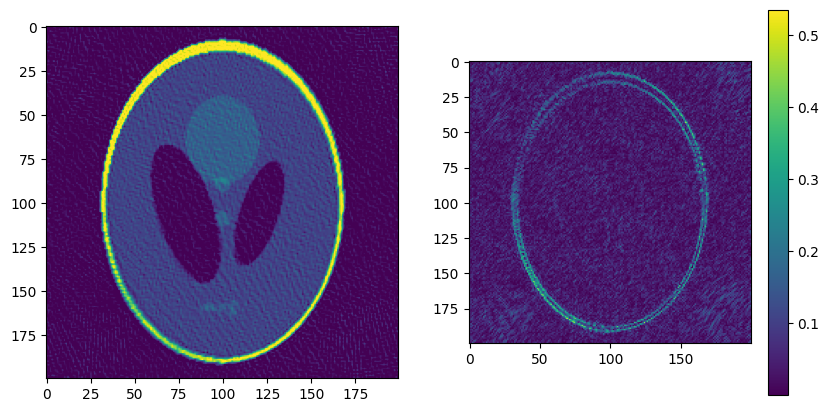

In [192]:
sol = my_direct_inversion(hori, vert, toeplitz_list, nufft_list)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sol, vmin=0., vmax=1.)
c = axes[1].imshow(np.abs(sol - im))
plt.colorbar(c, ax=axes[1])

In [197]:
polar_x, polar_y = polar_grid(angles, n_r=n_r)
hori, vert = direct_2d_interp(old_polar_fourier_transform(im, thetas=angles, n_r=n_r), polar_x, polar_y, n)

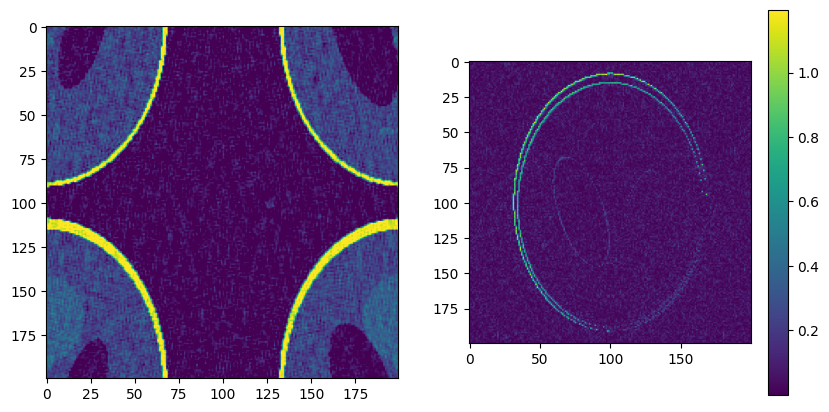

In [198]:
sol = my_direct_inversion(hori, vert, toeplitz_list, nufft_list)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sol, vmin=0., vmax=1.)
c = axes[1].imshow(np.abs(fft.fftshift(sol) - im))
plt.colorbar(c, ax=axes[1])

In [199]:
polar_x, polar_y = polar_grid(angles, n_r=n_r)
old_polar = old_polar_fourier_transform(im, thetas=angles, n_r=n_r)
old_polar *= np.exp(-2j * np.pi * (domain(n_r) / n_r)[None, :] * (n // 2) * (np.cos(angles) + np.sin(angles))[:, None])
hori, vert = direct_2d_interp(old_polar, polar_x, polar_y, n)

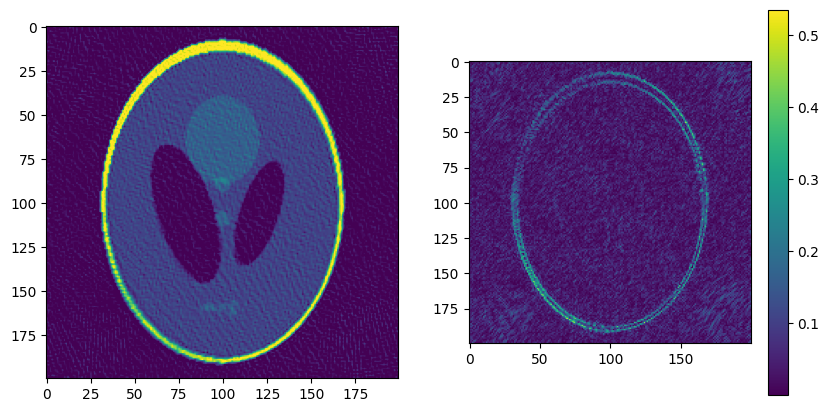

In [201]:
sol = my_direct_inversion(hori, vert, toeplitz_list, nufft_list)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sol, vmin=0., vmax=1.)
c = axes[1].imshow(np.abs(sol - im))
plt.colorbar(c, ax=axes[1])

# From sinogram

In [34]:
from silx.image.projection import Projection

from ppfft.tools.new_fft import new_fft
from ppfft.tools.pad import pad

In [206]:
n = 200
toeplitz_list, nufft_list = precompute_onion_peeling(n)

In [207]:
im = generate_phantom(n)

thetas = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n)
n_r = 2 * n + 1

proj = Projection(im.shape, angles=thetas)
sinogram = proj.projection(im)
pad_sino = np.pad(sinogram, ((0, 0), (0, n_r - n))) # zero-padding the sinogram to increase the radial samples
fft_sinogram = fft.fftshift(fft.fft(pad_sino), axes=-1)

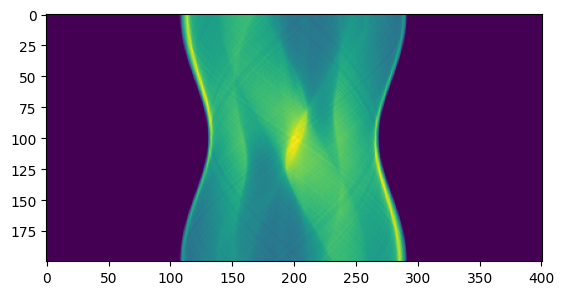

In [208]:
plt.imshow(pad_sino)

In [209]:
polar_ft = polar_fourier_transform(im, thetas=np.pi / 2 + thetas, n_r=2*n)

KeyboardInterrupt: 

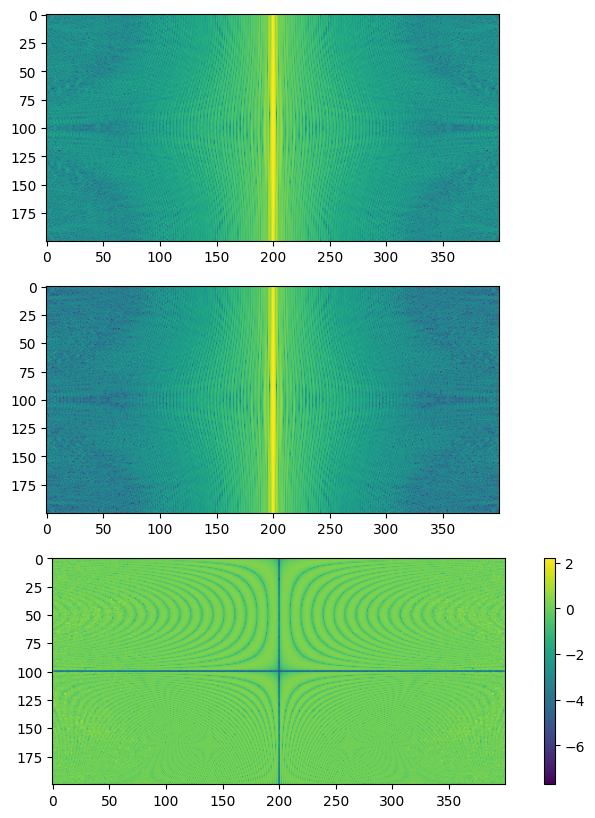

In [103]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

axes[0].imshow(np.log10(np.abs(polar_ft)))
axes[1].imshow(np.log10(np.abs(fft_sinogram)))
c = axes[2].imshow(np.log10(np.abs(polar_ft - fft_sinogram)) - np.log10(np.abs(polar_ft)))
plt.colorbar(c, ax=axes[2])

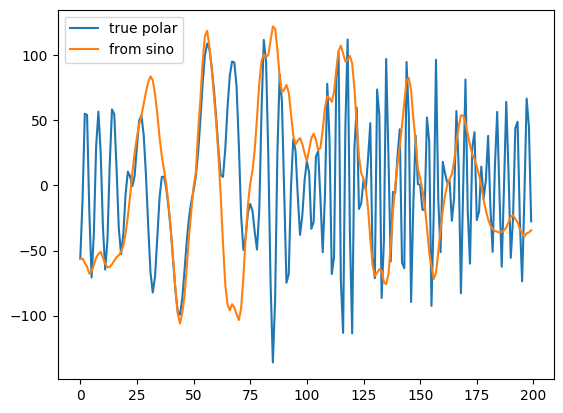

In [105]:
k = 50
plt.plot(polar_ft[:, 200 + k].real, label="true polar")
plt.plot(fft_sinogram[:, 200 + k].real, label="from sino")
plt.legend()

In [106]:
polar_x, polar_y = polar_grid(np.pi / 2 + thetas, 2 * n)
hori_sino, vert_sino = direct_2d_interp(fft_sinogram, polar_x, polar_y, n)
hori_polar, vert_polar = direct_2d_interp(polar_ft, polar_x, polar_y, n)

In [107]:
true_hori, true_vert = ppfft_horizontal(im), ppfft_vertical(im)

/tmp/ipykernel_4750/2086710885.py:3: RuntimeWarning: divide by zero encountered in log10
  axes[0, 0].imshow(np.log10(np.abs(hori_polar.real)))
/tmp/ipykernel_4750/2086710885.py:6: RuntimeWarning: divide by zero encountered in log10
  axes[0, 1].imshow(np.log10(np.abs(hori_polar.imag)))
/tmp/ipykernel_4750/2086710885.py:7: RuntimeWarning: divide by zero encountered in log10
  axes[1, 1].imshow(np.log10(np.abs(true_hori.imag)))


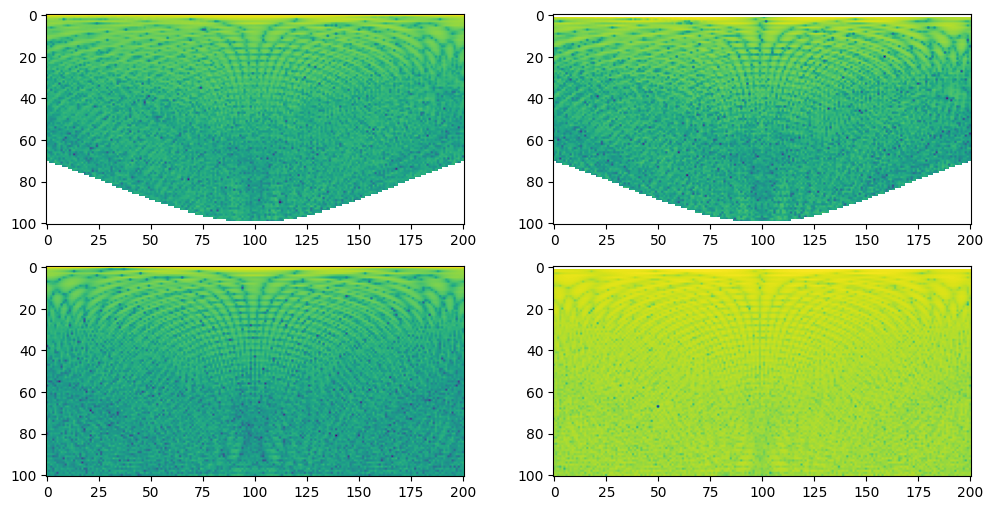

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

axes[0, 0].imshow(np.log10(np.abs(hori_polar.real)))
axes[1, 0].imshow(np.log10(np.abs(true_hori.real)))

axes[0, 1].imshow(np.log10(np.abs(hori_polar.imag)))
axes[1, 1].imshow(np.log10(np.abs(true_hori.imag)))

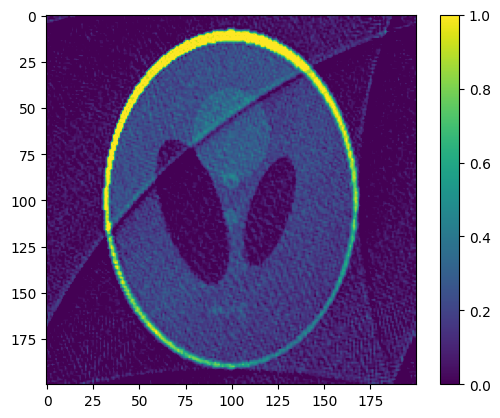

In [109]:
sol = my_direct_inversion(hori_polar, vert_polar, toeplitz_list, nufft_list)
plt.imshow(sol, vmin=0., vmax=1.)
plt.colorbar()

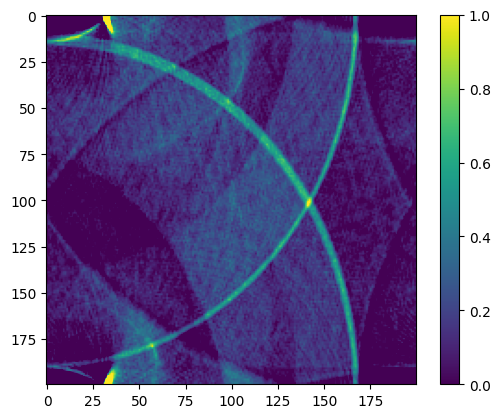

In [110]:
sol = my_direct_inversion(hori_sino, vert_sino, toeplitz_list, nufft_list)
plt.imshow(sol)
plt.colorbar()

In [35]:
from ppfft.tools.pad import pad
from ppfft.tools.new_fft import new_fft

In [79]:
n = 400
im = generate_phantom(n)
toeplitz_list, nufft_list = precompute_onion_peeling(n)

thetas = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n)

n_r = 4 * n + 1
proj = Projection(im.shape, angles=thetas)
sinogram = proj.projection(im)
pad_sino = pad(sinogram, (n, n_r)) # zero-padding the sinogram to increase the radial samples
fft_sinogram = new_fft(pad_sino)

In [80]:
angles = np.pi / 2 + thetas
fft_sinogram *= np.exp(-2j * np.pi * (domain(n_r) / n_r)[None, :] * (n // 2) * (np.cos(angles) + np.sin(angles))[:, None])

In [81]:
polar_x, polar_y = polar_grid(angles, n_r)
hori_sino, vert_sino = direct_2d_interp(fft_sinogram, polar_x, polar_y, n, LinearNDInterpolator)

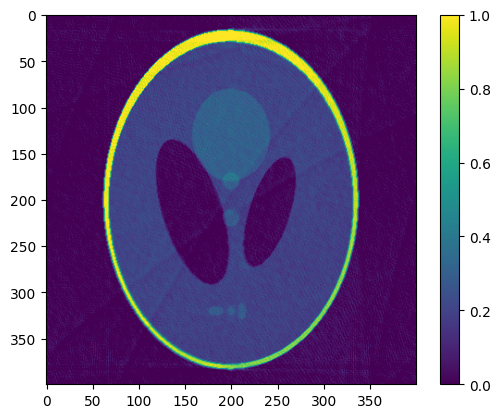

In [82]:
sol = my_direct_inversion(hori_sino, vert_sino, toeplitz_list, nufft_list)
plt.imshow(sol, vmin=0, vmax=1)
plt.colorbar()

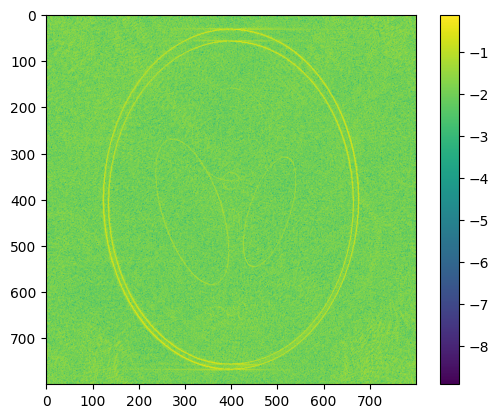

In [225]:
plt.imshow(np.log10(np.abs(sol - im)))
plt.colorbar()

# Try RBFInterpolator

In [36]:
from silx.image.projection import Projection

In [61]:
from scipy.interpolate import RBFInterpolator

In [83]:
def rbf_direct_2d_interp(polar_ft, polar_x, polar_y, n):
    """
    2d interpolation from polar gird to pseudo-polar.

    Parameters
    ----------
    polar_ft : np.ndarray
        Samples of the polar Fourier transform. Shape: (n_theta, n_r).
    x : np.ndarray
        x coordinates of the polar grid. Shape: (n_theta, n_r).
    y : np.ndarray
        y coordinates of the polar grid. Shape: (n_theta, n_r).
    n : int
        Size of the original image.
    interp_fun : class, optional
        2d Interpolator used.

    Returns
    -------
    hori_ppfft : np.ndarray
        Inteprolated horizontal ppfft. Shape: (n+1, n+1).
    vert_ppfft : np.ndarray
        Inteprolated vertical ppfft. Shape: (n+1, n+1).
    """

    points = np.stack((polar_x.flatten(), polar_y.flatten()), axis=-1)
    uniq_points, idx = np.unique(points, return_index=True, axis=0)

    interpolator = RBFInterpolator(uniq_points, np.take(polar_ft.flatten(), idx), neighbors=20, kernel='linear')

    hori_x, hori_y = half_horizontal_grid(n)

    hori_ppfft = interpolator(np.stack((hori_x.flatten(), hori_y.flatten()), axis=-1)).reshape(hori_x.shape)
    vert_ppfft = interpolator(np.stack((hori_y.flatten(), hori_x.flatten()), axis=-1)).reshape(hori_x.shape)

    return hori_ppfft, vert_ppfft

In [84]:
n = 400
im = generate_phantom(n)
toeplitz_list, nufft_list = precompute_onion_peeling(n)

thetas = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n)

n_r = 4 * n + 1
proj = Projection(im.shape, angles=thetas)
sinogram = proj.projection(im)
pad_sino = pad(sinogram, (n, n_r)) # zero-padding the sinogram to increase the radial samples
fft_sinogram = new_fft(pad_sino)

In [85]:
angles = np.pi / 2 + thetas
fft_sinogram *= np.exp(-2j * np.pi * (domain(n_r) / n_r)[None, :] * (n // 2) * (np.cos(angles) + np.sin(angles))[:, None])

In [86]:
polar_x, polar_y = polar_grid(angles, n_r)
hori_sino, vert_sino = rbf_direct_2d_interp(fft_sinogram, polar_x, polar_y, n)

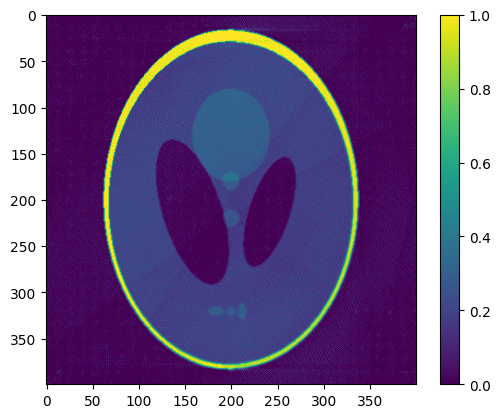

In [87]:
sol = my_direct_inversion(hori_sino, vert_sino, toeplitz_list, nufft_list)
plt.imshow(sol, vmin=0, vmax=1)
plt.colorbar()

# Test

In [2]:
from ppfft.reconstruction.reconstruction import reconstruction
from ppfft.reconstruction.new_reconstruction import new_reconstruction
from ppfft.inverse.onion_peeling import precompute_onion_peeling
from ppfft.inverse.new_onion_peeling import precompute_new_onion_peeling
from ppfft.tools.phantom_generator import generate_phantom

from silx.image.projection import Projection


In [3]:
n = 800
toeplitz_list, nufft_list = precompute_onion_peeling(n)
im = generate_phantom(n)

thetas = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n)

proj = Projection(im.shape, angles=thetas)
sinogram = proj.projection(im)

In [4]:
sol = reconstruction(sinogram, thetas, (toeplitz_list, nufft_list))

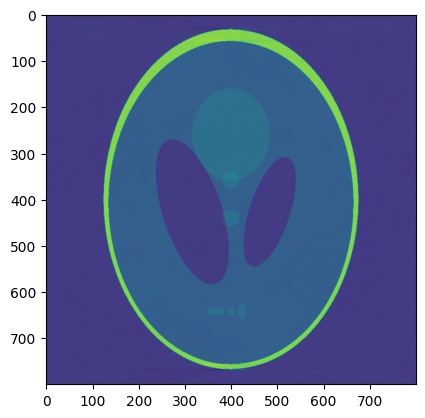

In [5]:
plt.imshow(sol)

In [6]:
n = 800
toeplitz_list, nufft_list = precompute_new_onion_peeling(n)
im = generate_phantom(n)

thetas = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n)

proj = Projection(im.shape, angles=thetas)
sinogram = proj.projection(im)

In [17]:
new_sol = new_reconstruction(sinogram, thetas, (toeplitz_list, nufft_list))

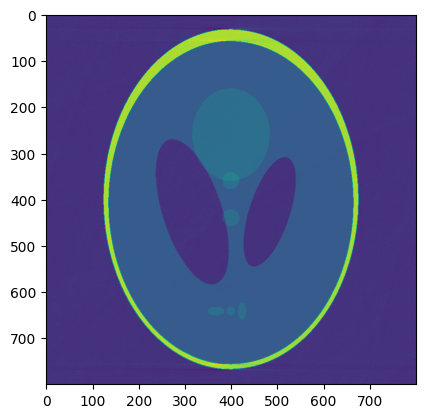

In [18]:
plt.imshow(new_sol)